<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/Colab_Compatible_CuPy_LBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

Setting up initial conditions...
Starting example simulation loop...
Plotting frame for t=0


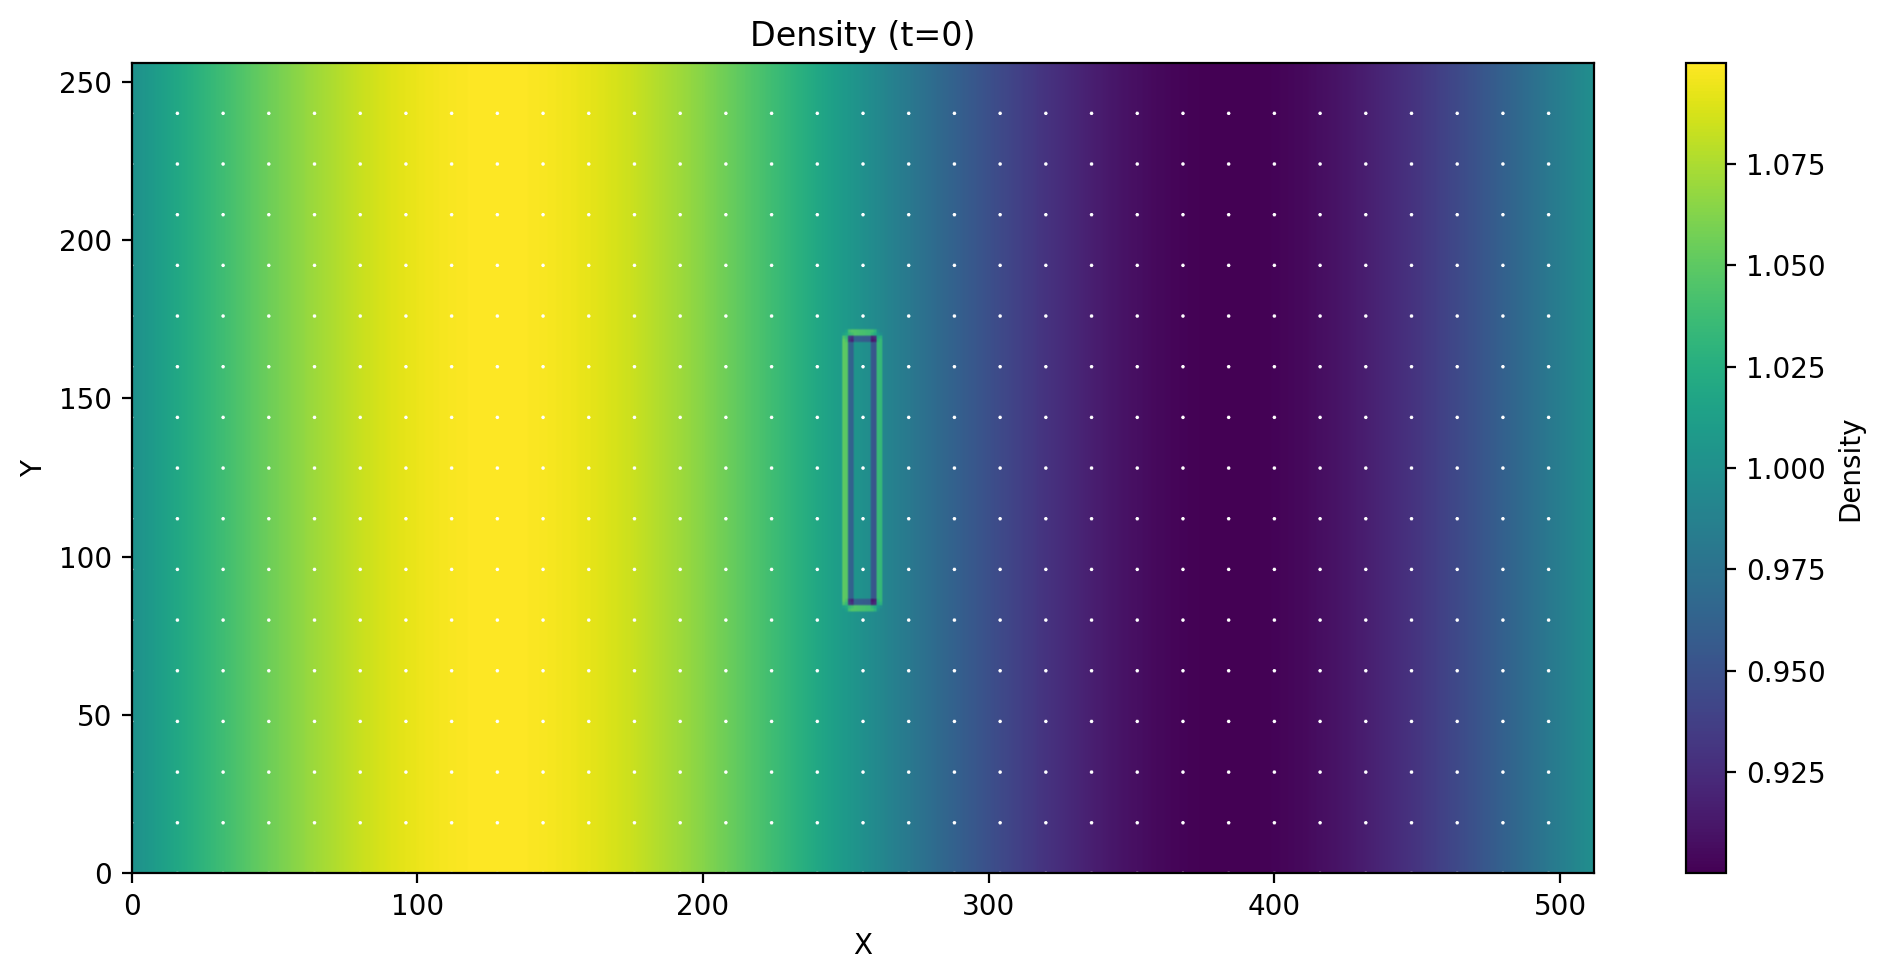

Plotting frame for t=10


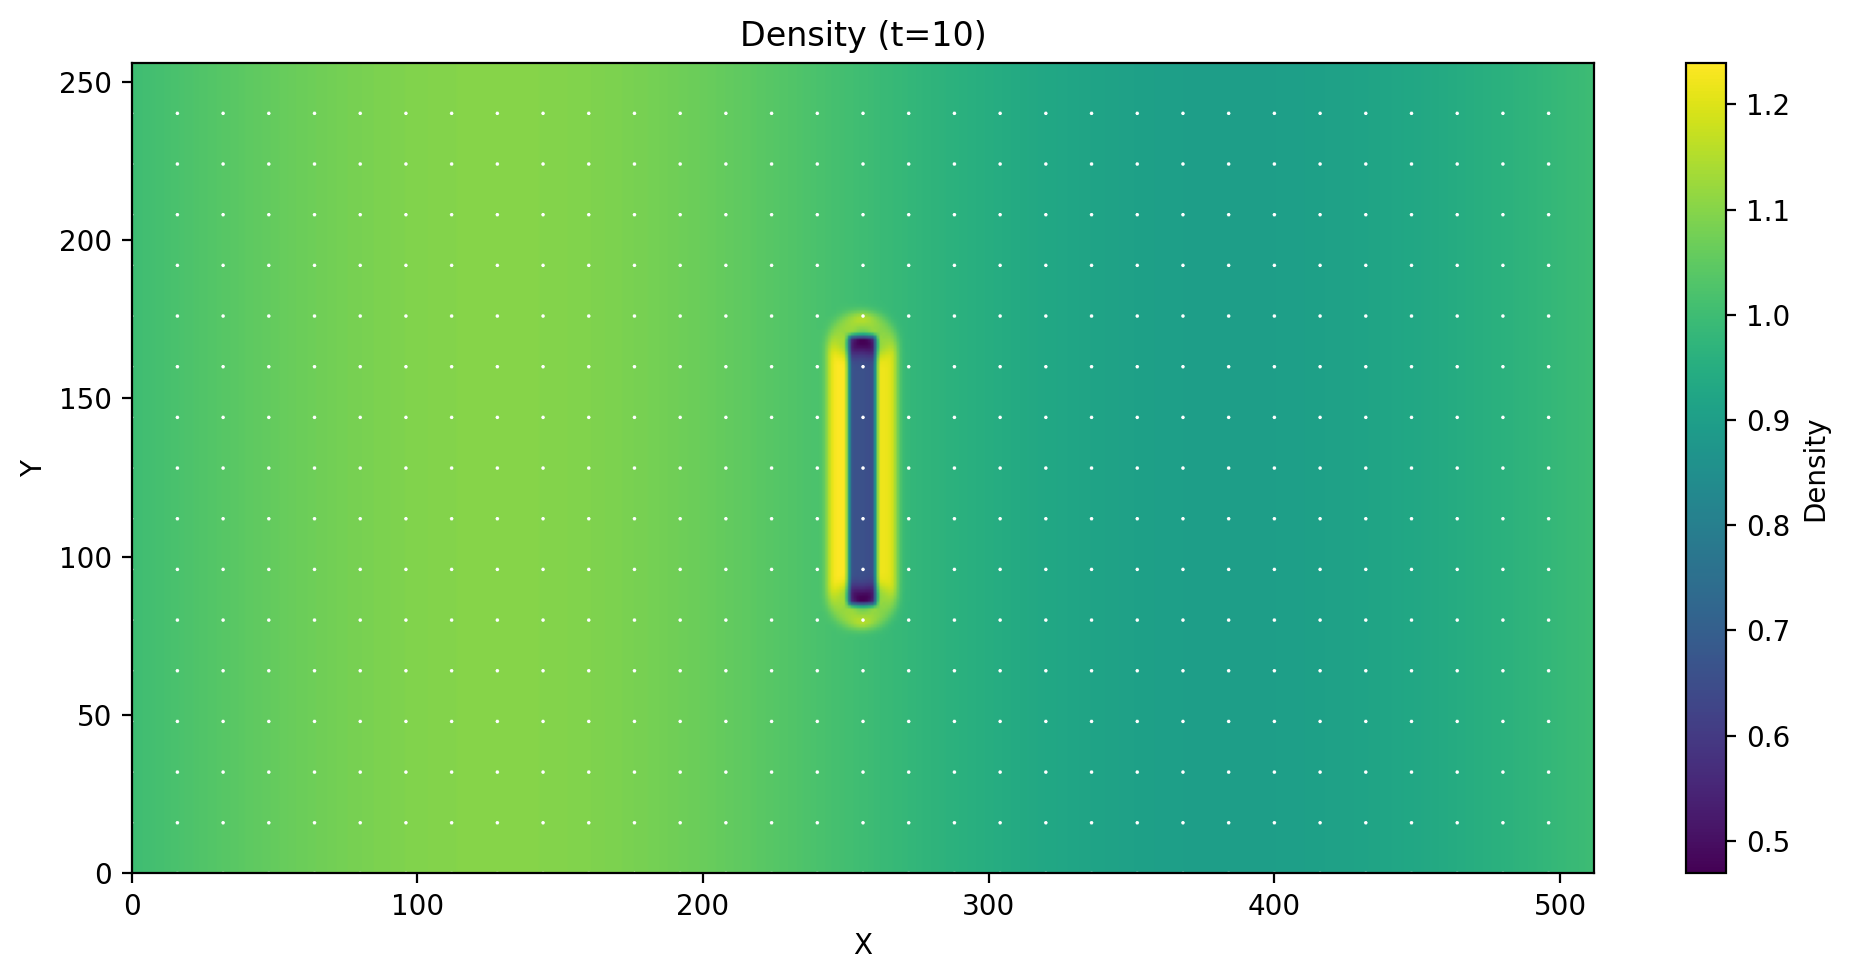

Plotting frame for t=20


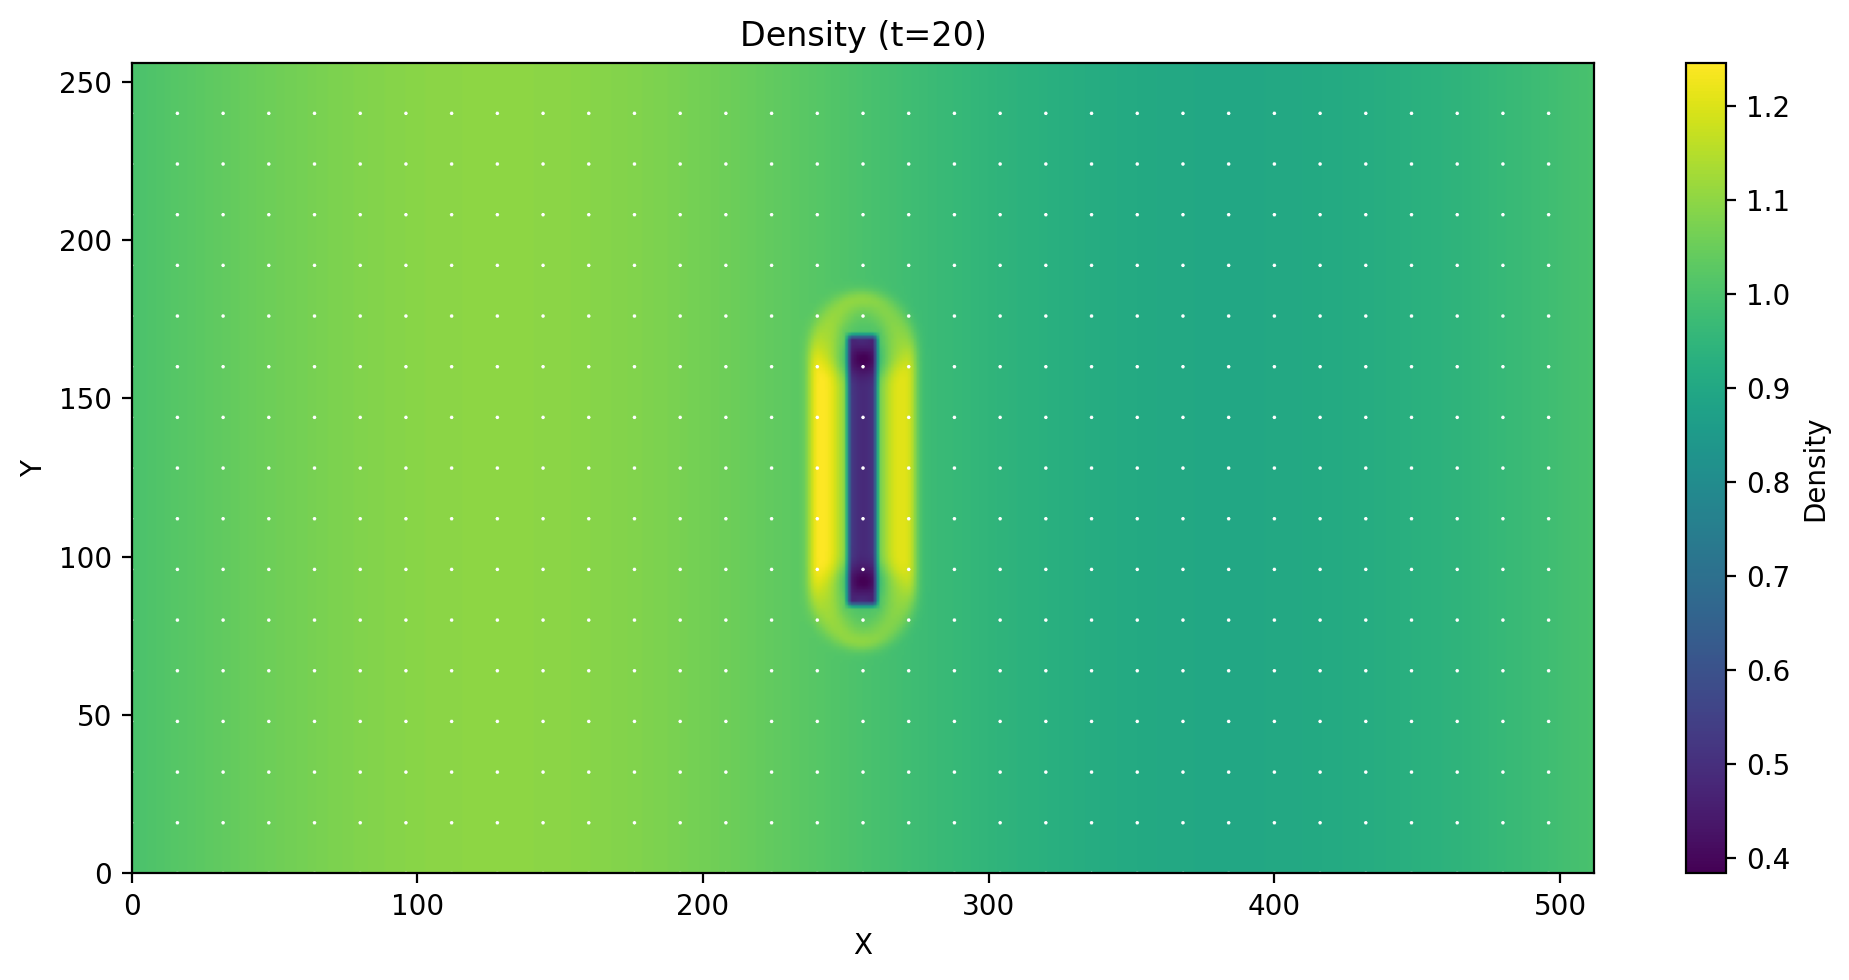

Plotting frame for t=30


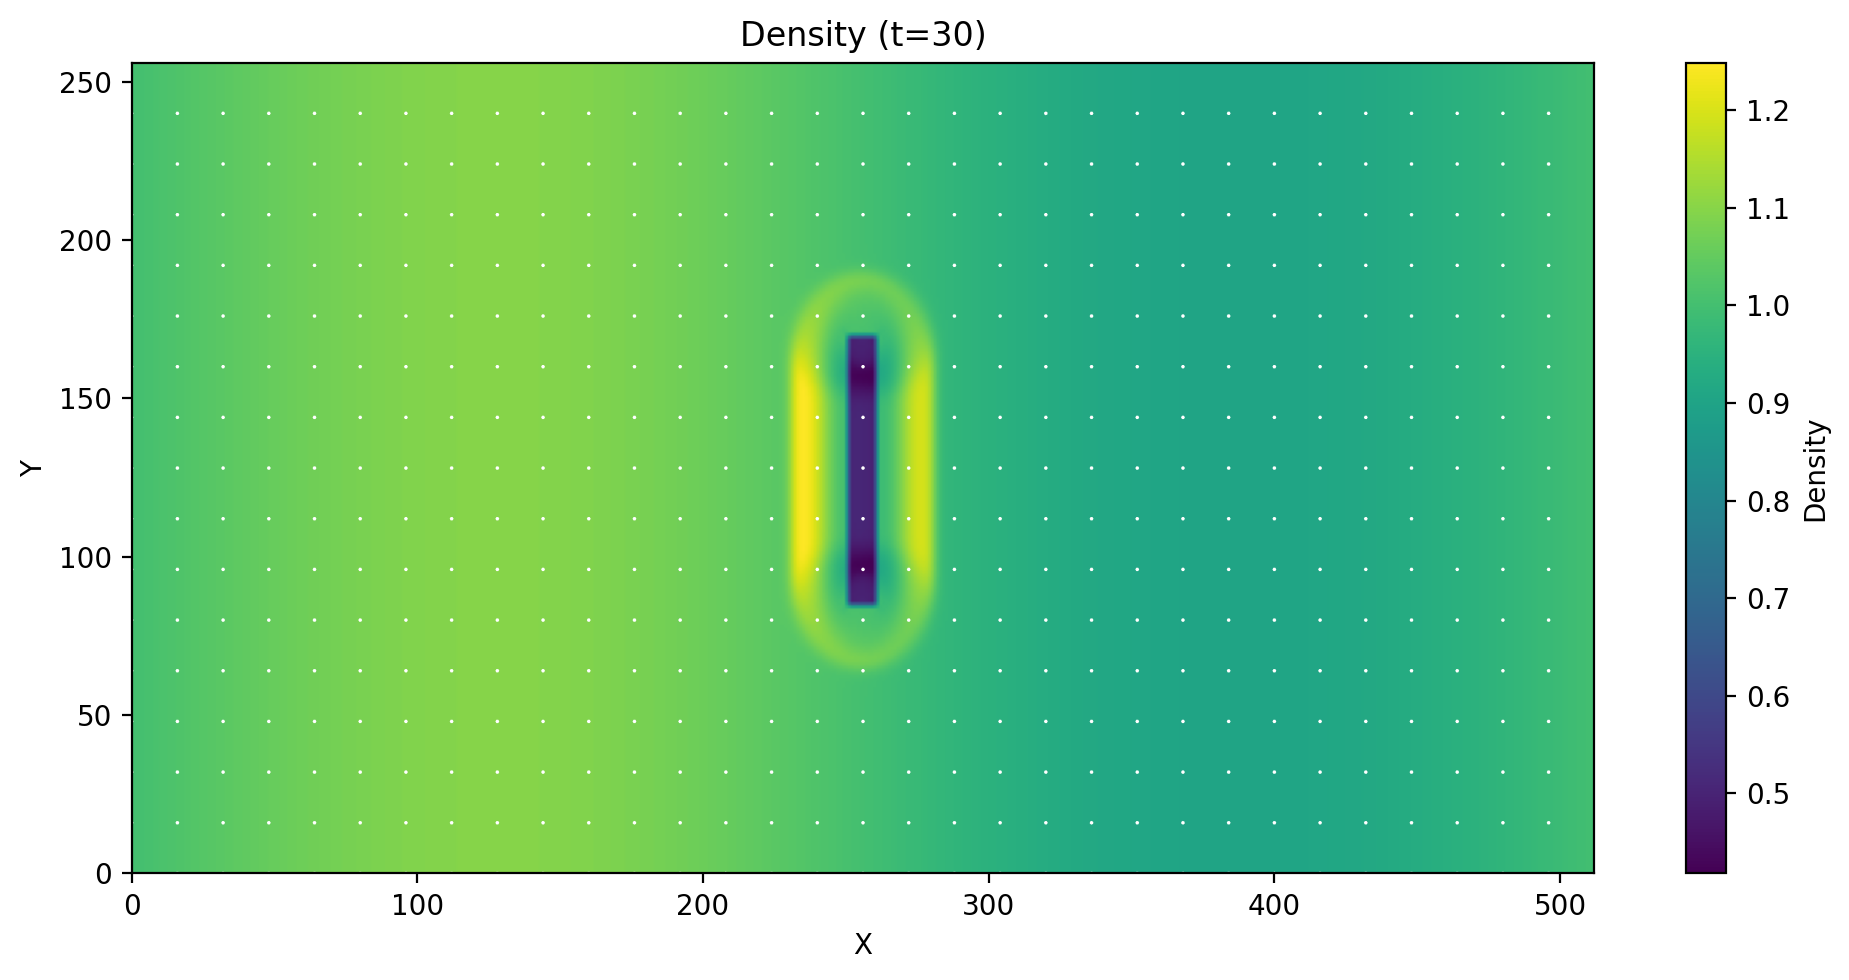

Plotting frame for t=40


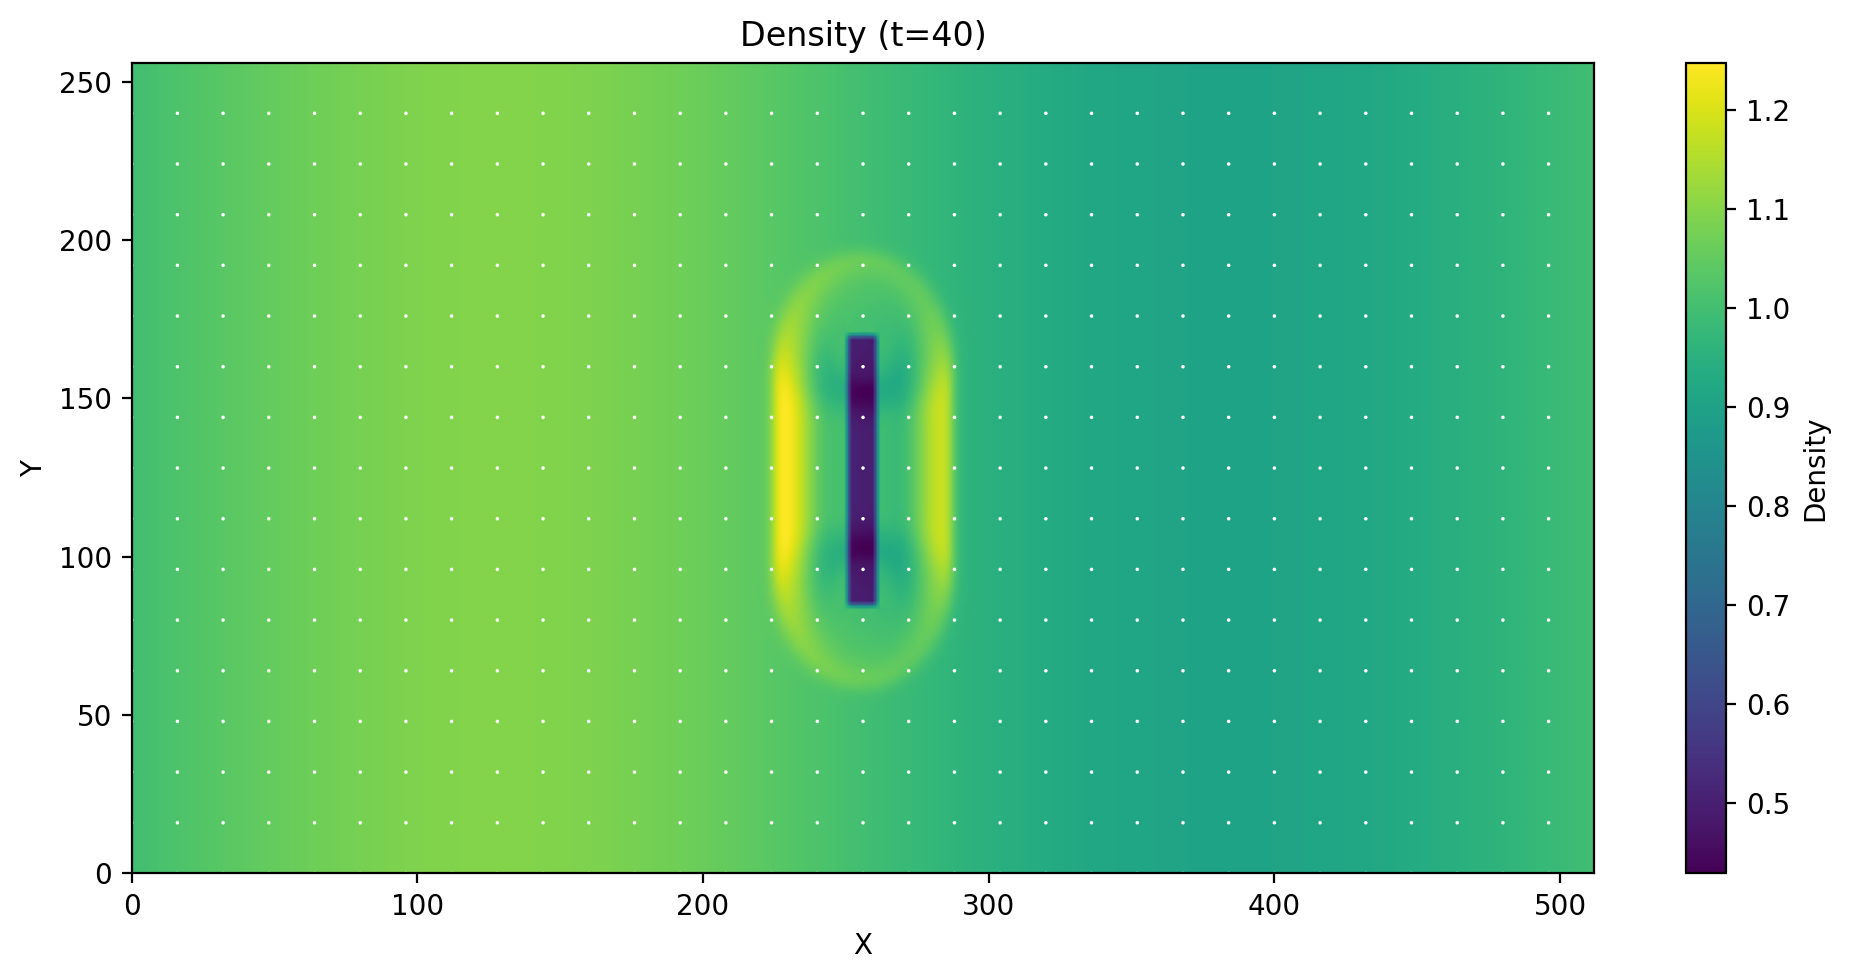

Example loop finished.


In [1]:
# === CuPy lattice-(quantum)-Boltzmann skeleton (2D, D2Q9) ===
#
# --- TO RUN IN GOOGLE COLAB (with L4 GPU or similar) ---
# 1. Ensure your runtime is a GPU (Runtime -> Change runtime type).
# 2. Run the following command
#
!pip install cupy-cuda$(nvcc --version | grep -o 'release [0-9]\+' | grep -o '[0-9]\+' | head -n1)x matplotlib
#
# 3. After installation, you can paste and run this entire file in a new cell.
# -----------------------------------------------------------------

try:
    import cupy as cp
    import matplotlib.pyplot as plt
except ImportError as e:
    print("="*50)
    print("IMPORT ERROR: ", e)
    print("\nPlease run the !pip install command in the header of this file in a separate Colab cell first.")
    print("You might need to restart the runtime after installation.")
    print("="*50)
    raise

# --- Set Matplotlib DPI for plots ---
# This ensures that any figures generated (e.g., with plt.show() or plt.savefig())
# will default to 200 DPI, which is useful for heat maps and vector fields.
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
# ------------------------------------

# ---- Control knobs (tunable) ----
DT      = 1.0
TAU     = 0.8             # relaxation time (BGK)
HBAR    = 1.0
MASS    = 1.0
ALPHA_B = 1.0             # Bohm-weight in QHD forcing (0..1)
MODEL   = "WIGNER"        # or "QHD"
JC      = 0.02            # Josephson critical current density (if used)
QPS_GAM = 0.0             # phase-slip rate per time-step per link node

# ---- Lattice (D2Q9) ----
c = cp.array([[0,0],[1,0],[0,1],[-1,0],[0,-1],[1,1],[-1,1],[-1,-1],[1,-1]], dtype=cp.int32)
w = cp.array([4/9]+[1/9]*4+[1/36]*4, dtype=cp.float64)

# ---- Fields ----
NX, NY = 512, 256
Q = 9
W = cp.zeros((Q, NX, NY), dtype=cp.float64)     # Wigner or LB populations
V = cp.zeros((NX, NY), dtype=cp.float64)        # external/barrier potential

# ---- Helpers ----
def macroscopic(W):
    n  = W.sum(axis=0) + 1e-14
    ux = (W * c[:,0,None,None]).sum(axis=0) / n
    uy = (W * c[:,1,None,None]).sum(axis=0) / n
    return n, ux, uy

def equilibrium(n, ux, uy):
    # 2nd-order Hermite (isothermal) equilibrium
    cu = cp.stack([(c[q,0]*ux + c[q,1]*uy) for q in range(Q)], axis=0)
    u2 = ux**2 + uy**2
    return w[:,None,None] * n * (1 + 3*cu + 4.5*cu**2 - 1.5*u2)

def bohm_force(n):
    # Q_B = -(ħ^2/2m) ∇^2 sqrt(n) / sqrt(n)
    s = cp.sqrt(n)
    lap = (-4*s + cp.roll(s,1,0)+cp.roll(s,-1,0)+cp.roll(s,1,1)+cp.roll(s,-1,1))
    QB = -(HBAR**2)/(2*MASS) * (lap / (s+1e-14))
    # return force density = -∇(QB)
    fx = 0.5*(cp.roll(QB,-1,0) - cp.roll(QB,1,0))
    fy = 0.5*(cp.roll(QB,-1,1) - cp.roll(QB,1,1))
    return fx, fy

def moyal_source(W, V):
    # Lowest-order Moyal truncation: ∝ ∇V · ∂_p W  (represented on the lattice as a forcing term)
    # Here we approximate by projecting ∇V onto lattice directions
    dVx = 0.5*(cp.roll(V,-1,0) - cp.roll(V,1,0))
    dVy = 0.5*(cp.roll(V,-1,1) - cp.roll(V,1,1))
    # project onto each discrete velocity; scale with HBAR once (dimensionless units)
    proj = cp.stack([c[q,0]*dVx + c[q,1]*dVy for q in range(Q)], axis=0)
    return -(DT*HBAR/(2*MASS)) * proj * w[:,None,None]

def tunneling_source(W, n, ux, uy, side="left"):
    # Placeholder: inject/extract to match a target tunneling current density J_tun from Meir–Wingreen or Josephson
    J = cp.zeros_like(n)
    # (i) Electron case: set J from Meir–Wingring I(V) per contact area; (ii) Superfluid: J = JC*sin(Δφ)
    return cp.stack([w[q]*J for q in range(Q)], axis=0)

# ---- One time step ----
def step(W, V):
    n, ux, uy = macroscopic(W)
    Weq = equilibrium(n, ux, uy)

    # Quantum forcing
    if MODEL == "WIGNER":
        S = moyal_source(W, V)
        Fx = Fy = 0.0
    else:  # QHD
        Fx, Fy = bohm_force(n)
        # Guo forcing term projection onto populations:
        S = cp.stack([ w[q] * (3*(c[q,0]*Fx + c[q,1]*Fy)) for q in range(Q) ], axis=0) * ALPHA_B

    # Collide
    W = W - (DT/TAU)*(W - Weq) + S

    # Add tunneling sources near barrier nodes (user fills J from NEGF/Josephson/QPS)
    W += tunneling_source(W, n, ux, uy, side="left")

    # Stream
    for q in range(Q):
        W[q] = cp.roll(cp.roll(W[q], c[q,0], axis=0), c[q,1], axis=1)

    return W

# ---- (Example) Main simulation loop (add plotting) ----
#
# To use this, you would need to:
# 1. Initialize your fields (W, V)
# 2. Call step() in a loop
# 3. Add your plotting logic inside the loop (e.g., every N steps)

# Example (uncomment to test plotting):
#
print("Setting up initial conditions...")
V[NX//2-5:NX//2+5, NY//3:2*NY//3] = 1.0  # Example barrier

# Initialize W to equilibrium with a small density gradient
x_coords = cp.arange(NX)[:, None]
n_init = 1.0 + 0.1 * cp.sin(2 * cp.pi * x_coords / NX)
n_init = cp.broadcast_to(n_init, (NX, NY)) # Ensure n_init is (NX, NY)

W = equilibrium(n_init, cp.zeros_like(n_init), cp.zeros_like(n_init))

print("Starting example simulation loop...")
for t in range(50):
    W = step(W, V)
    if t % 10 == 0:
        print(f"Plotting frame for t={t}")
        n, ux, uy = macroscopic(W)

        plt.figure(figsize=(10, 5)) # Figure size in inches

        # Plot density heat map
        plt.imshow(cp.asnumpy(n.T), origin='lower', cmap='viridis', aspect='auto')
        plt.title(f"Density (t={t})")
        plt.colorbar(label='Density')

        # Overlay vector field (quiver plot)
        # Subsample for performance and clarity
        skip = 16

        # Create meshgrid for plotting
        # Note: Meshgrid in NumPy/CuPy for plotting should match the data *layout*
        # X goes from 0 to NX-1, Y from 0 to NY-1
        X, Y = cp.meshgrid(cp.arange(NX), cp.arange(NY), indexing='ij')

        # Subsample data
        X_sub = cp.asnumpy(X[::skip, ::skip])
        Y_sub = cp.asnumpy(Y[::skip, ::skip])

        # Transpose ux and uy for plotting to match imshow's (n.T) orientation
        ux_sub = cp.asnumpy(ux.T[::skip, ::skip])
        uy_sub = cp.asnumpy(uy.T[::skip, ::skip])

        # Plot the quiver field
        # Note: Quiver's X, Y, U, V are all 2D arrays of the same shape.
        # Here X_sub, Y_sub specify coordinates, and ux_sub, uy_sub specify vectors.
        # We use .T on ux/uy data to match the .T on density (n).
        plt.quiver(X_sub, Y_sub, ux_sub, uy_sub,
                   color='white', scale=5, scale_units='xy', angles='xy') # Adjust scale as needed

        plt.xlabel("X")
        plt.ylabel("Y")
        plt.xlim(0, NX)
        plt.ylim(0, NY)
        plt.tight_layout()
        plt.savefig(f"frame_{t:04d}.png") # DPI is set by rcParams
        plt.show() # Show plot inline in Colab
        plt.close() # Close figure to free memory

print("Example loop finished.")